(model_configuration)=
# Model Configuration

This goes over the model configuration

## Setup

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from pymc_marketing.model_config import parse_model_config
from pymc_marketing.prior import Prior

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

## Prior Distributions

The `Prior` class is our way to expression distributions and relationships between them.

### Basic Usage

Every prior will need a distribution name that comes from `PyMC`

In [2]:
scalar_distribution = Prior("Normal")
scalar_distribution

Prior("Normal")

If not, then an exception will be raised

In [3]:
try:
    Prior("UnknownDistribution")
except Exception as e:
    print(e)

PyMC doesn't have a distribution of name 'UnknownDistribution'


Specific parameters can be passed as **keyword arguments** but are not required if the `PyMC` distribution has defaults.

In [4]:
scalar_distribution = Prior("Normal", mu=0, sigma=3.5)
scalar_distribution

Prior("Normal", mu=0, sigma=3.5)

There will be a check at initialization against the `PyMC` distribution.

In [5]:
try:
    Prior("Normal", mu=0, b=1)
except Exception as e:
    print(e)

Parameters {'mu', 'b'} are not a subset of the pymc distribution parameters {'mu', 'sigma', 'tau'}


However, there are some limitations to that. Take this invalid parameterization below:

In [6]:
invalid_distribution = Prior("Normal", mu=1, sigma=1, tau=2)

The `create_variable` method is used to make variables from this distribution and it isn't until then that there is an error.

In [7]:
with pm.Model():
    try:
        invalid_distribution.create_variable("mu")
    except Exception as e:
        print(e)

Can't pass both tau and sigma


This goes for incorrect values as well!

In [8]:
invalid_distribution = Prior("Normal", mu=1, sigma=-1)
invalid_distribution

Prior("Normal", mu=1, sigma=-1)

The `dims` parameter are used to express the dimensions of the distribution. This variable is not part of a model so the values are not reflected with the distribution itself.

In [9]:
vector_distribution = Prior("Normal", dims="channel")
vector_distribution

Prior("Normal", dims="channel")

If there are dimensions, then the coords need to exist in the larger model. But they exist separately and can defined in advance.

```{tip}
Each `Prior` instance is just instructions to create a variable, so they can be used multiple times!
```

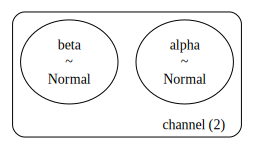

In [10]:
coords = {"channel": ["C1", "C2"]}
with pm.Model(coords=coords) as model:
    alpha = vector_distribution.create_variable("alpha")
    beta = vector_distribution.create_variable("beta")

pm.model_to_graphviz(model)

If the coords were not specified then this would cause a PyMC error.

In [11]:
with pm.Model() as model:
    try:
        vector_distribution.create_variable("var")
    except Exception as e:
        print(e)

"Dimensions {'channel'} are unknown to the model and cannot be used to specify a `shape`."


The variables can get arbitrarily large as well by providing additional dims in a tuple.

In [12]:
matrix_distribution = Prior("Normal", dims=("channel", "geo"))
matrix_distribution

Prior("Normal", dims=("channel", "geo"))

In [13]:
tensor_distribution = Prior("Normal", dims=("channel", "geo", "store"))
tensor_distribution

Prior("Normal", dims=("channel", "geo", "store"))

### Hierarchical Variables

Hierarchical variables can be defined by using distributions as the parameters of another distribution. The parent distributions will usually have a larger dimensionality than each of the parameters.

In [14]:
hierarchical_variable = Prior(
    "Normal",
    mu=Prior("Normal"),
    sigma=Prior("HalfNormal"),
    dims="channel",
)

We can use the `graph` method to create visualize the variable with dummy coordinates.

```{note}
No need to worry about variable naming! The child parameters will all be automatically named based on the parent.
```

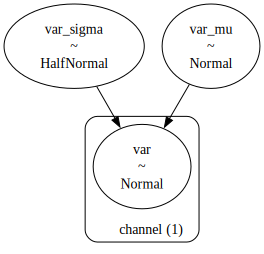

In [15]:
hierarchical_variable.graph()

```{warning}
The validity of the parameter values will not be checked. 
```

There can be negative sigma parameter in a Normal distribution whether that comes from value or another distribution!

In [16]:
Prior("Normal", mu=1, sigma=-1)

Prior("Normal", mu=1, sigma=-1)

In [17]:
Prior("Normal", sigma=Prior("Normal"))

Prior("Normal", sigma=Prior("Normal"))

```{tip}
Model reparamterizations can help with model convergence depending on the model posterior!
```

For Normal distribution, the common non-centered parameterization is supported with the `centered` flag.

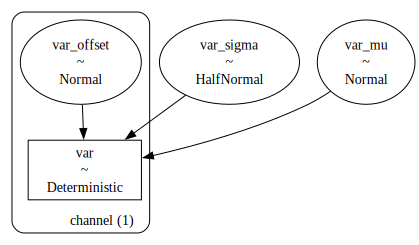

In [18]:
non_centered_hierarchical_variable = Prior(
    "Normal",
    mu=Prior("Normal"),
    sigma=Prior("HalfNormal"),
    dims="channel",
    # Flag for non-centered
    centered=False,
)
non_centered_hierarchical_variable.graph()

Other distributions can be hierarchical as well. Just use distributions for parameters of a parent distribution. For instance, the Beta distribution has two positive parameters, `alpha` and `beta` which can be reflect as HalfNormal distributions.

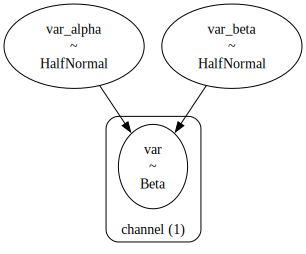

In [19]:
zero_to_one_variable = Prior(
    "Beta",
    alpha=Prior("HalfNormal"),
    beta=Prior("HalfNormal"),
    dims="channel",
)
zero_to_one_variable.graph()

### Transformations

The `transform` variable can be used for any of the distributions to change its domain.

These transformations will be taken from `pytensor.tensor` or `pm.math` in that order.

Below is a non-centered hierarchical Normal distribution that is put through a sigmoid function in order to change the domain to (0, 1).

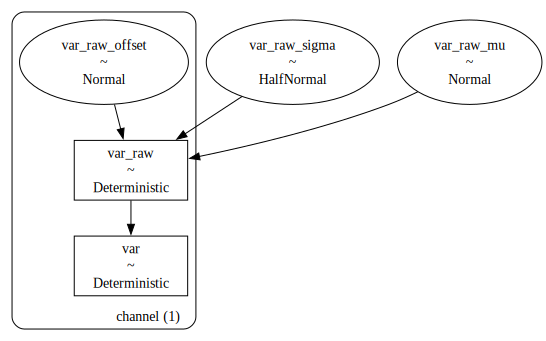

In [20]:
hierarchical_zero_to_one_distribution = Prior(
    "Normal",
    mu=Prior("Normal"),
    sigma=Prior("HalfNormal"),
    dims="channel",
    centered=False,
    transform="sigmoid",
)
hierarchical_zero_to_one_distribution.graph()

### Prior Visualization

For scalar distributions, make use of the `preliz` attribute of the model in order to visualize. 

```{tip}
Defaults for the parameters will have to be provided or there will be an error.
```

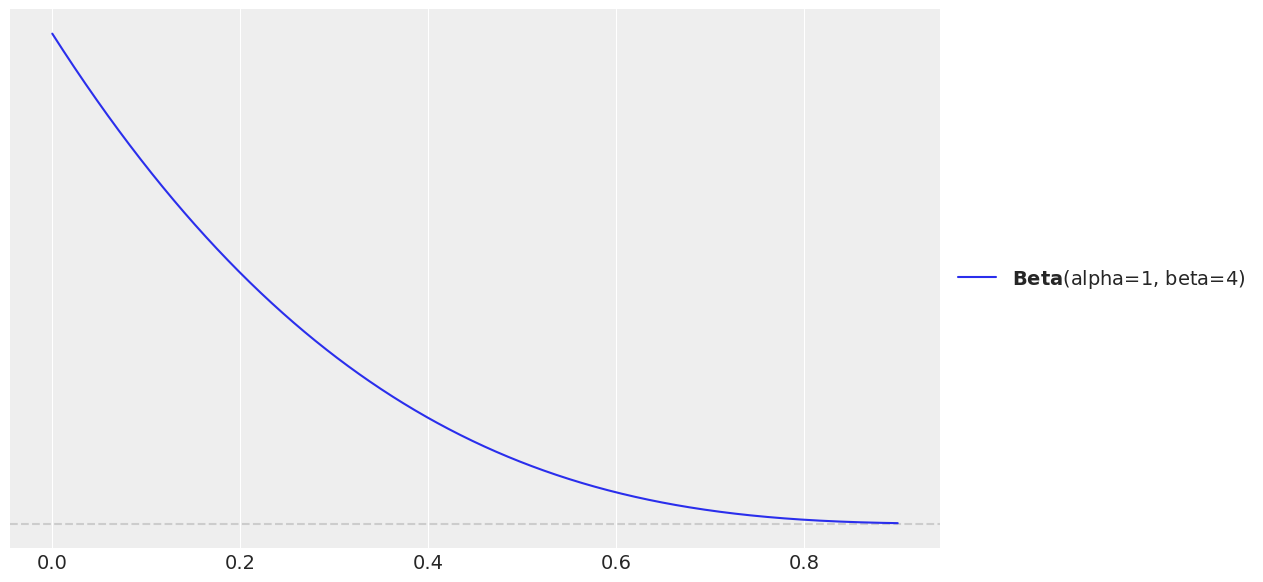

In [21]:
beta_distribution = Prior("Beta", alpha=1, beta=4)

beta_distribution.preliz.plot_pdf();

```{tip}
Using the `constrain` method can help hone in on a prior. It is a wrapper around the ever-so-helpful [`find_constrained_prior` function](https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.find_constrained_prior.html). The `init_guess` is taken to be the parameters of the instance distribution.
```

In [22]:
constrained_distribution = Prior("Normal", mu=5, sigma=1).constrain(lower=4, upper=6)
constrained_distribution

Prior("Normal", mu=5.000013661179942, sigma=0.5102135210258302)

For more complicated distributions, consider using the `sample_prior` method in order to access the prior.

```{note}
Any coordinates will have to be passed like in `pm.Model`.
```

In [23]:
complicated_distribution = Prior(
    "Normal",
    mu=Prior("Normal", sigma=1),
    sigma=Prior("HalfNormal", sigma=.25),
   #sigma=Prior("Normal", sigma=0.0, transform="exp"),
    centered=False,
    dims="channel",
    transform="sigmoid",
)

coords = {
    "channel": ["C1", "C2"],
}
prior = complicated_distribution.sample_prior(coords=coords)
prior

Sampling: [var_raw_mu, var_raw_offset, var_raw_sigma]


<xarray.Dataset> Size: 36kB
Dimensions:         (chain: 1, draw: 500, channel: 2)
Coordinates:
  * chain           (chain) int64 8B 0
  * draw            (draw) int64 4kB 0 1 2 3 4 5 6 ... 494 495 496 497 498 499
  * channel         (channel) <U2 16B 'C1' 'C2'
Data variables:
    var_raw_mu      (chain, draw) float64 4kB -1.203 -0.5095 ... 2.034 0.4014
    var_raw         (chain, draw, channel) float64 8kB -0.6256 -1.169 ... 0.3137
    var             (chain, draw, channel) float64 8kB 0.3485 0.237 ... 0.5778
    var_raw_sigma   (chain, draw) float64 4kB 0.1998 0.1987 ... 0.201 0.05183
    var_raw_offset  (chain, draw, channel) float64 8kB 2.892 0.1708 ... -1.692
Attributes:
    created_at:                 2024-06-21T09:02:30.435271
    arviz_version:              0.17.0
    inference_library:          pymc
    inference_library_version:  5.14.0

The prior variables can be visualized in whatever way works best. Here is a histogram of the variables.

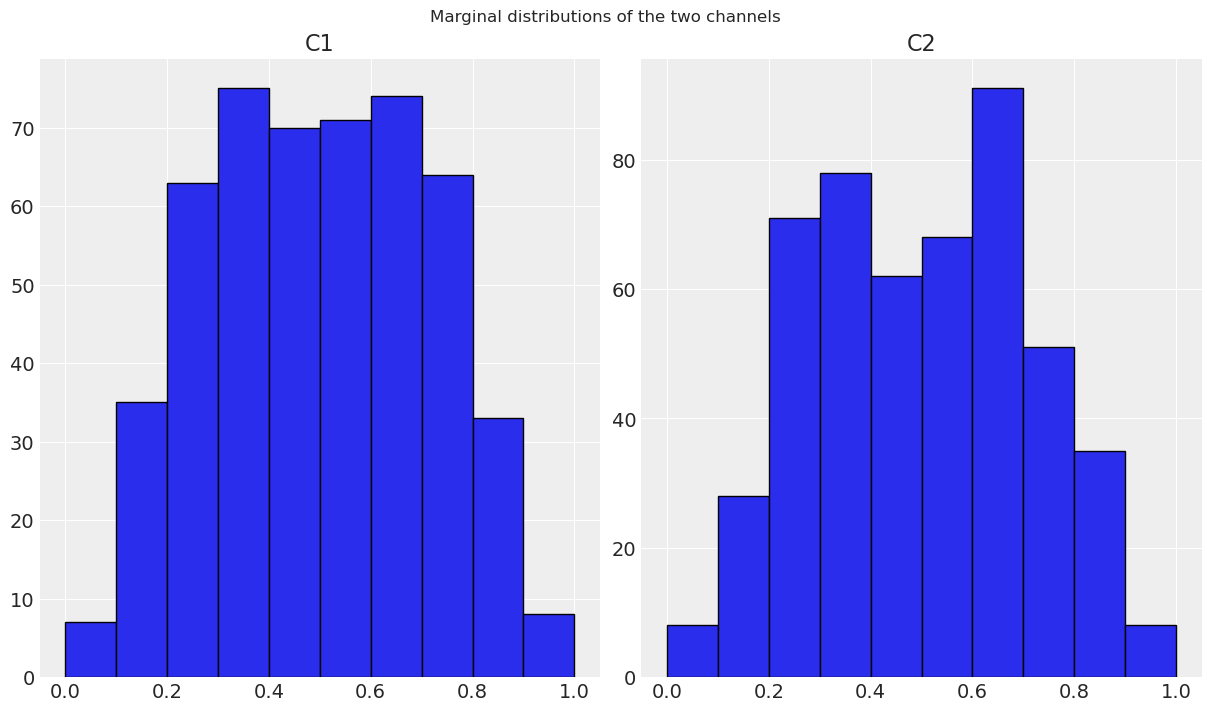

In [24]:
bins = np.arange(0, 1.1, 0.1)
prior["var"].to_series().unstack().hist(bins=bins, edgecolor="black")
plt.gcf().suptitle("Marginal distributions of the two channels");

Use any workflow to make sense of the prior distribution! For instance, the correlation between two of these channels.

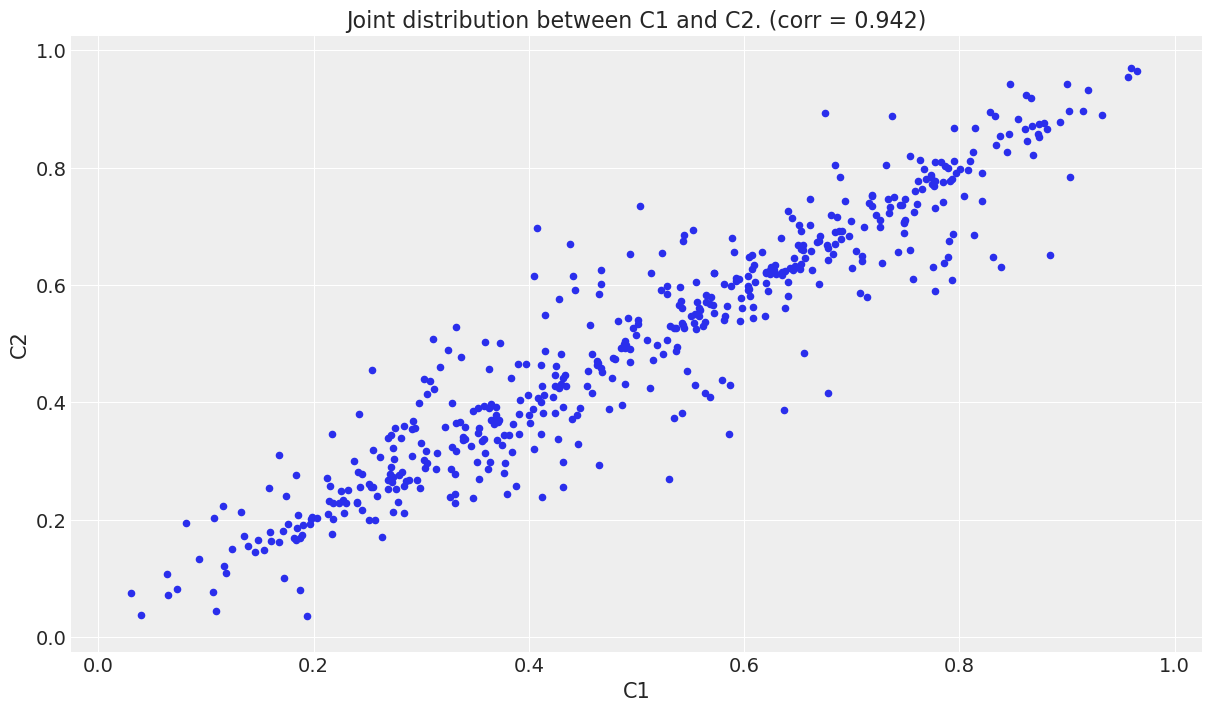

In [25]:
def plot_correlation(df: pd.DataFrame, x: str = "C1", y: str = "C2") -> plt.Axes:
    corr = df.loc[:, [x, y]].corr().iloc[0, 1]
    title = f"Joint distribution between {x} and {y}. ({corr = :.3f})"
    return df.plot.scatter(x=x, y=y, title=title)


ax = prior["var"].to_series().unstack().pipe(plot_correlation)
padding = 0.025
bounds = (0 - padding, 1 + padding)
ax.set(xlim=bounds, ylim=bounds);

### Automatic Broadcasting

The broadcasting of the dims will be handled automatically.

For instance, the `mu` of the variable needs to be transposed in order to work with ("channel", "geo") dims.

With all this functionality, we can see that the prior distributions can become quite expressive!

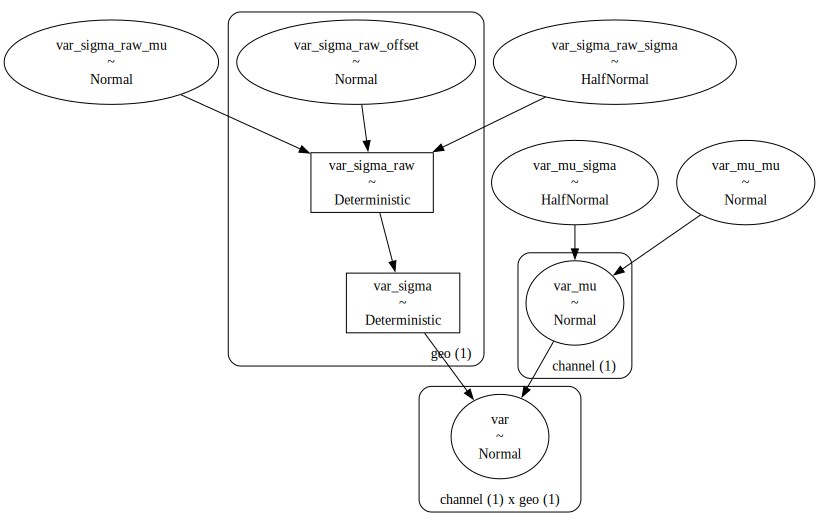

In [26]:
def create_2d_variable(mu_dims, sigma_dims) -> Prior:
    mu = Prior(
        "Normal",
        mu=Prior("Normal"),
        sigma=Prior("HalfNormal"),
        dims=mu_dims,
    )
    sigma = Prior(
        "Normal",
        mu=Prior("Normal"),
        sigma=Prior("HalfNormal"),
        centered=False,
        dims=sigma_dims,
        transform="exp",
    )
    return Prior(
        "Normal",
        mu=mu,
        sigma=sigma,
        dims=("channel", "geo"),
    )


variable_2d = create_2d_variable(mu_dims="channel", sigma_dims="geo")
variable_2d.graph()

And the user can spend more time thinking about just the assumptions of the variables rather than logic to ensure the dimensions work.

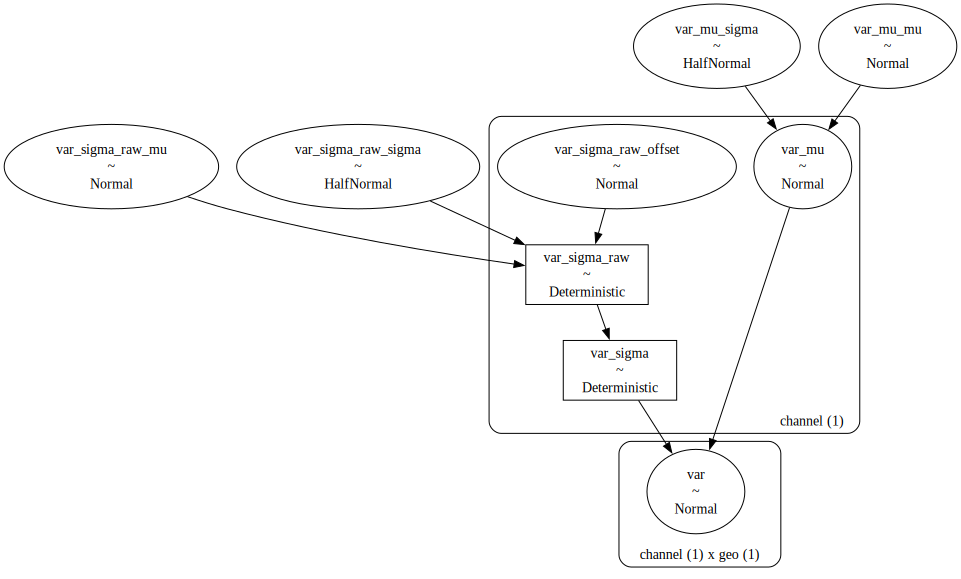

In [27]:
different_assumptions_2d = create_2d_variable(mu_dims="channel", sigma_dims="channel")

different_assumptions_2d.graph()

### Serialization

The `to_json` and `from_json` methods can be helpful for storage of the distributions.

In [28]:
variable_2d_dict = variable_2d.to_json()
variable_2d_dict

{'dist': 'Normal',
 'kwargs': {'mu': {'dist': 'Normal',
   'kwargs': {'mu': {'dist': 'Normal'}, 'sigma': {'dist': 'HalfNormal'}},
   'dims': ('channel',)},
  'sigma': {'dist': 'Normal',
   'kwargs': {'mu': {'dist': 'Normal'}, 'sigma': {'dist': 'HalfNormal'}},
   'centered': False,
   'dims': ('geo',),
   'transform': 'exp'}},
 'dims': ('channel', 'geo')}

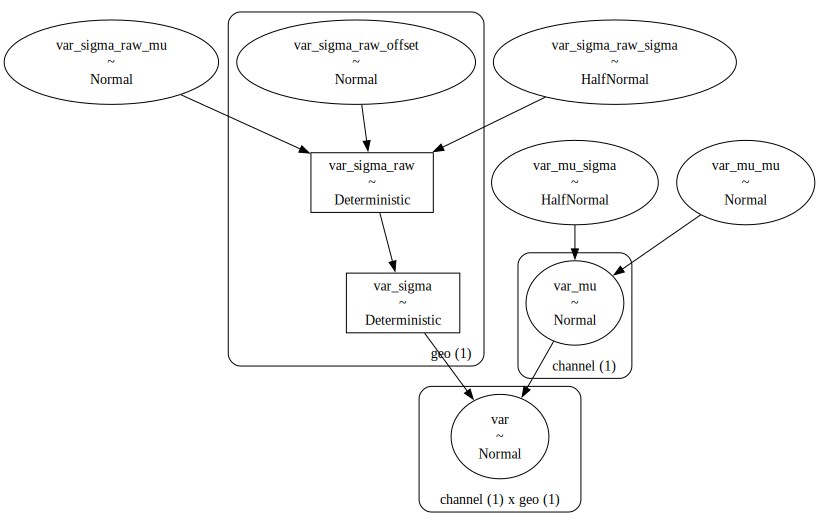

In [29]:
Prior.from_json(variable_2d_dict).graph()

## Use in PyMC-Marketing

Distributions will be expressed in this manner throughout the package including but not limited to: 

- MMM components
    - media transformations
 
### Backwards compatibility

The `from_json` method will create a `Prior` instance from the previous format.

For instance, take this previous configuration: 

In [30]:
old_model_config = {
    "alpha": {
        "dist": "Normal",
        "kwargs": {
            "mu": 0,
            "sigma": 1,
        },
    },
    "beta": {
        "dist": "Laplace",
        "kwargs": {
            "mu": 1,
            "b": 0.5,
        },
    },
}

This can be parsed with the `Prior.from_json` constructor for each key. Much more consise too!

In [31]:
new_model_config = {
    name: Prior.from_json(key)
    for name, key in
    old_model_config.items()
}

new_model_config

{'alpha': Prior("Normal", mu=0, sigma=1),
 'beta': Prior("Laplace", mu=1, b=0.5)}

In [32]:
new_model_config["alpha"].to_json()

{'dist': 'Normal', 'kwargs': {'mu': 0, 'sigma': 1}}

The `parse_model_config` function will do just this and is used internally. It also provides some deprecation warnings.

In [33]:
parse_model_config(old_model_config)

{'alpha': Prior("Normal", mu=0, sigma=1),
 'beta': Prior("Laplace", mu=1, b=0.5)}